In [9]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_excel('/content/Sample Data.xlsx', index_col=0)

# Extract the 'Year' and 'Keywords' columns
df = df[['Year', 'keywords']]

# Drop rows with NaN values in the 'Keywords' column
df = df.dropna(subset=['keywords'])

# Convert the keywords column to string type
df['keywords'] = df['keywords'].astype(str)

# Split the keywords column by '|' and create a list of keywords for each row
df['keywords'] = df['keywords'].str.split('|')

# Create a list of keywords to search for
keywords_to_search = ['deep learning','imaging', 'machine learning','convolutional neural network','computational pathology', 'digital pathology','VIDEOMICROSCOPY', '2D-barcode', 'digital imaging', 'image processing', 'neural network']

# Create a boolean mask for rows that contain the keywords
mask = df['keywords'].apply(lambda x: any(keyword in x for keyword in keywords_to_search))

# Apply the boolean mask to filter the rows
df_filtered = df[mask]

# Explode the keywords column to create separate rows for each keyword
df_filtered = df_filtered.explode('keywords')

# Group by year and keyword, and count the occurrences
result = df_filtered.groupby(['Year', 'keywords']).size().unstack(fill_value=0)

# Reset the index to make years as columns and keywords as rows
result = result.reset_index()

# Rename the columns for readability
result.columns.name = None

# Set the 'Year' column as the index
result.set_index('Year', inplace=True)

# Filter the resulting DataFrame to only include the keywords in keywords_to_search
result = result[result.columns.intersection(keywords_to_search)]

# Reset the index to make years as columns and keywords as rows
result = result.reset_index()

# Print the resulting DataFrame
print(result)



    Year  2D-barcode  VIDEOMICROSCOPY  computational pathology  \
0   1990           0                1                        0   
1   1991           0                2                        0   
2   1992           0                4                        0   
3   1993           0               12                        0   
4   1994           0                5                        0   
5   1995           0               13                        0   
6   1996           0                0                        0   
7   1997           0                0                        0   
8   1998           0                0                        0   
9   1999           0                0                        0   
10  2000           0                0                        0   
11  2002           0                0                        0   
12  2003           0                0                        0   
13  2004           0                0                        0   
14  2005  

In [10]:
# Save the filtered DataFrame as an Excel file
result.to_excel('filtered_results.xlsx', index=False)

In [11]:
new_df = pd.read_excel('filtered_results.xlsx', index_col=0)

In [7]:
import numpy as np
# Calculate CAGR for each keyword
result_cagr = pd.DataFrame(index=new_df.columns, columns=['CAGR'])
for keyword in new_df.columns:
    start_value = new_df[keyword].loc[new_df[keyword].ne(0).idxmax()]  # First non-zero value
    end_value = new_df[keyword].iloc[-1]  # Value in the last row
    n = new_df[keyword].ne(0).sum()  # Number of non-zero values
    cagr = (end_value / start_value)**(1 / n) - 1  # Calculate CAGR
    result_cagr.at[keyword, 'CAGR'] = cagr if cagr != np.inf else np.nan

# Calculate share of keywords
result_share = pd.DataFrame(index=df.columns, columns=['Share'])
for keyword in new_df.columns:
    last_two_years_sum = new_df[keyword].iloc[-2:].sum()  # Sum of values for last two years
    total_sum = new_df[keyword].sum()  # Sum of all years
    share = (last_two_years_sum / total_sum) * 100  # Calculate share as percentage
    result_share.at[keyword, 'Share'] = share

    # Calculate average of shares
avg_share = result_share['Share'].mean()

# Create a new column to store quartile information
result_share['Quartile'] = ''
result_cagr['Quartile'] = ''

# Loop through each keyword
for keyword in new_df.columns:
    share = result_share.at[keyword, 'Share']
    cagr = result_cagr.at[keyword, 'CAGR']

    if share > avg_share:
        if cagr >= 0:
            result_share.at[keyword, 'Quartile'] = 'Dominant Technologies'
            result_cagr.at[keyword, 'Quartile'] = 'Dominant Technologies'
        else:
            result_share.at[keyword, 'Quartile'] = 'Saturated Technologies'
            result_cagr.at[keyword, 'Quartile'] = 'Saturated Technologies'
    else:
        if cagr > 0:
            result_share.at[keyword, 'Quartile'] = 'Emerging Technologies'
            result_cagr.at[keyword, 'Quartile'] = 'Emerging Technologies'
        else:
            result_share.at[keyword, 'Quartile'] = 'Declining Technologies'
            result_cagr.at[keyword, 'Quartile'] = 'Declining Technologies'

# Calculate sum of frequency for node size
result_freq_sum = new_df.sum()

In [ ]:
# Print CAGR results
print("CAGR Results:")
print(result_cagr)

# Print Share results
print("Share Results:")
print(result_share)


CAGR Results:
                                  CAGR                Quartile
2D-barcode                        -1.0  Saturated Technologies
VIDEOMICROSCOPY                   -1.0  Declining Technologies
computational pathology       0.257433   Dominant Technologies
convolutional neural network  0.681793   Dominant Technologies
deep learning                 0.878922   Dominant Technologies
digital imaging                    0.0  Declining Technologies
digital pathology             0.256496   Dominant Technologies
image processing                   0.0  Declining Technologies
imaging                            0.0  Declining Technologies
machine learning              0.471644   Dominant Technologies
neural network                     0.0  Declining Technologies
Share Results:
                                  Share                Quartile
Year                                NaN                        
keywords                            NaN                        
2D-barcode             

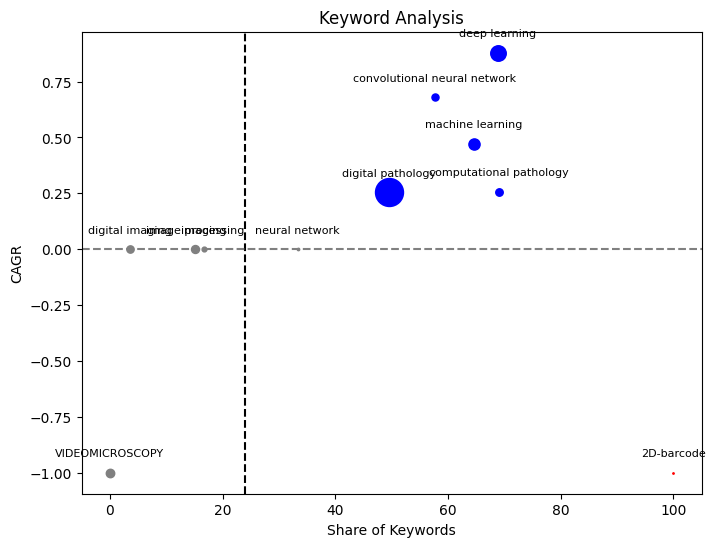

In [8]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))  # Update figsize to desired width and height in inches

# Define colors for each quartile
colors = {
    'Emerging Technologies': 'green',
    'Dominant Technologies': 'blue',
    'Saturated Technologies': 'red',
    'Declining Technologies': 'gray'
}

# Loop through each keyword
for keyword in new_df.columns:
    share = result_share.at[keyword, 'Share']
    cagr = result_cagr.at[keyword, 'CAGR']
    freq_sum = result_freq_sum.at[keyword]

    # Get the quartile for the keyword
    quartile = result_cagr.at[keyword, 'Quartile']

    # Get the color and size based on the quartile and frequency sum
    color = colors[quartile]
    size = freq_sum 

    # Plot the keyword as a scatter point with label
    ax.scatter(share, cagr, c=color, s=size, label=keyword)

    # Add text label for each keyword
    ax.annotate(keyword, (share, cagr), textcoords="offset points", xytext=(0, 10), ha='center', va='bottom', fontsize=8)
    
# Calculate mean of x-axis and plot vertical line
mean_share = new_df.sum(axis=1).mean()
ax.axvline(mean_share, color='black', linestyle='--', label='Mean Share')

# Plot horizontal line for CAGR = 0
ax.axhline(0, color='gray', linestyle='--', label='CAGR = 0')

# Set labels and title
ax.set_xlabel('Share of Keywords')
ax.set_ylabel('CAGR')
ax.set_title('Keyword Analysis')


# Show the plot
plt.show()


In [ ]:
mean_share

23.90625

In [ ]:
import pandas as pd
import matplotlib as plt
import pymannkendall as mk
import numpy as np

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Keyword', 'Test Statistic', 'p-value', 'Trend', 'h', 'z', 'Tau', 's', 'var_s', 'slope'])

# Loop through each keyword column in the DataFrame
for col in new_df.columns:
    # Perform Mann-Kendall test on the column
    result = mk.original_test(new_df[col].values)
    
    # Extract the test statistic, p-value, and trend (if any)
    test_statistic = result[0]
    p_value = result[1]
    trend = result[2]
    h = result[3]
    z = result[4]
    Tau = result[5]
    s = result[6]
    var_s = result[7]
    slope = result[8]

    
# Append the results to the DataFrame
    results_df = results_df.append({'Keyword': col, 'Test Statistic': test_statistic, 'p-value': p_value, 'Trend': trend, 'h': h, 'z': z, 'Tau': Tau, 's': s, 'var_s': var_s, 'slope': slope}, ignore_index=True)

# Print the results in tabular format
print(results_df)

                         Keyword Test Statistic p-value         Trend  \
0                     2D-barcode       no trend   False  1.294473e-01   
1                VIDEOMICROSCOPY     decreasing    True  6.739610e-04   
2        computational pathology     increasing    True  9.855433e-04   
3   convolutional neural network     increasing    True  1.625225e-03   
4                  deep learning     increasing    True  5.758708e-05   
5                digital imaging       no trend   False  3.572759e-01   
6              digital pathology     increasing    True  1.873732e-10   
7               image processing     increasing    True  4.946290e-03   
8                        imaging     increasing    True  2.832999e-02   
9               machine learning     increasing    True  6.660667e-06   
10                neural network       no trend   False  5.606628e-01   

           h         z    Tau            s     var_s     slope  
0   1.516285  0.058468   29.0   341.000000  0.000000  0.00

C:\Users\admin\AppData\Local\Temp\ipykernel_14484\296267327.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Keyword': col, 'Test Statistic': test_statistic, 'p-value': p_value, 'Trend': trend, 'h': h, 'z': z, 'Tau': Tau, 's': s, 'var_s': var_s, 'slope': slope}, ignore_index=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_14484\296267327.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Keyword': col, 'Test Statistic': test_statistic, 'p-value': p_value, 'Trend': trend, 'h': h, 'z': z, 'Tau': Tau, 's': s, 'var_s': var_s, 'slope': slope}, ignore_index=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_14484\296267327.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

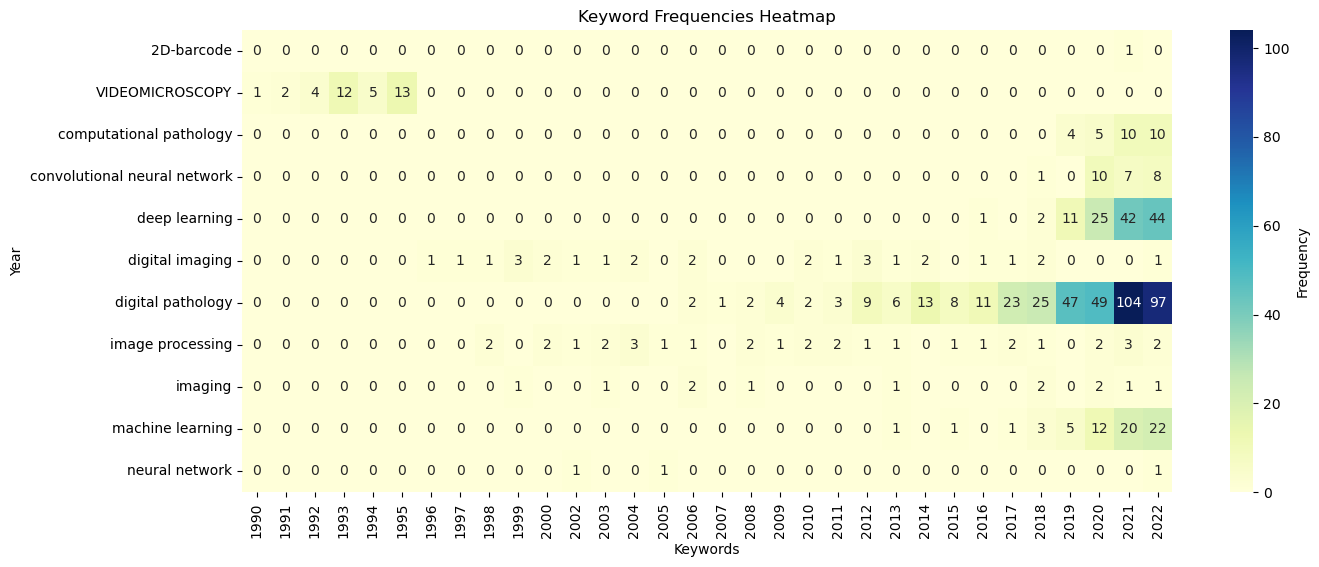

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Transpose the DataFrame to switch the years to x-axis and keywords to y-axis
df_transposed = new_df.T


# Set the plot size
plt.figure(figsize=(15, 6))

# Create a heatmap using seaborn
sns.heatmap(df_transposed, cmap='YlGnBu', cbar_kws={'label': 'Frequency'}, annot=True, fmt="d")

# Set the title and labels
plt.title('Keyword Frequencies Heatmap')
plt.xlabel('Keywords')
plt.ylabel('Year')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

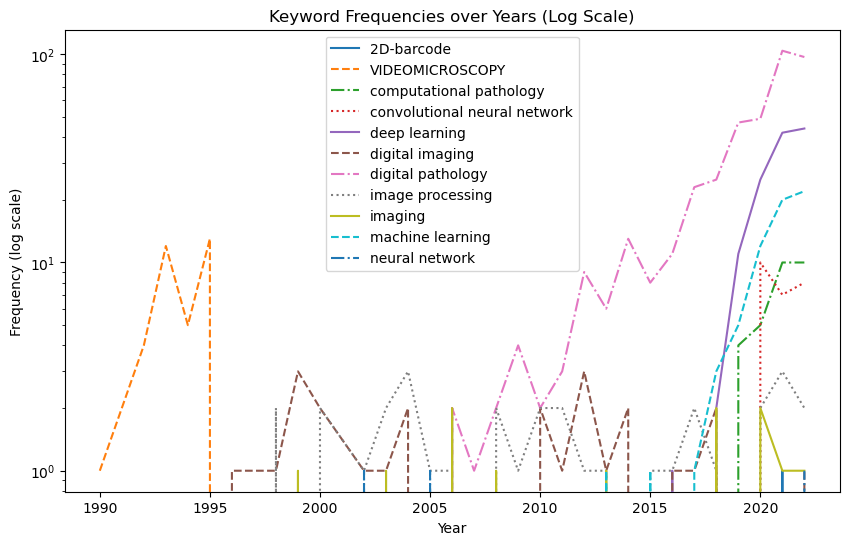

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Set plot style for lines
line_styles = ['-', '--', '-.', ':']  # Specify different line styles
num_styles = len(line_styles)

# Set plot size
plt.figure(figsize=(10, 6))

# Loop through each column (keyword) in the DataFrame and plot a line
for i, column in enumerate(new_df.columns):
    # Get x-axis (years) and y-axis (frequencies) data
    x = new_df.index
    y = new_df[column]
    
    # Plot the line with the specified style and label
    plt.plot(x, y, linestyle=line_styles[i % num_styles], label=column)

# Set log scale for y-axis
plt.yscale('log')

# Set title and labels
plt.title('Keyword Frequencies over Years (Log Scale)')
plt.xlabel('Year')
plt.ylabel('Frequency (log scale)')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def klinsberg_burst_detection(values, threshold=0.5, min_burst_length=2):
    """
    Detect bursts in a time series using the Kinsberg algorithm.
   
    Args:
        values (np.array): 1D numpy array of values.
        threshold (float): Threshold value for detecting bursts. Default is 3.
        min_burst_length (int): Minimum length of a burst to be considered. Default is 2.
   
    Returns:
        bursts (list): List of dictionaries containing 'Weight', 'Length', 'Start', and 'End' values for each burst.
    """
    bursts = []
    n = len(values)
    mean = np.mean(values)
    std = np.std(values)
   
    for i in range(n):
        if values[i] > mean + threshold * std:
            start = i
            end = i
            weight = values[i] - mean
            length = 1
           
            # Extend the burst
            for j in range(i+1, n):
                if values[j] > mean + threshold * std and j == end + 1:
                    weight += values[j] - mean
                    end = j
                    length += 1
                else:
                    break
           
            # Check if the burst meets the minimum length requirement
            if length >= min_burst_length:
                burst = {'Weight': weight, 'Length': length, 'Start': start, 'End': end}
                bursts.append(burst)
   
    return bursts

# Read the Excel file into a DataFrame
new_df = pd.read_excel('filtered_results.xlsx', index_col=0)

# Get all column names except for the 'Year' column
keywords = new_df.columns.tolist()[1:]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Keyword', 'Weight', 'Length', 'Start', 'End'])

# Loop through each keyword and calculate bursts
for keyword in keywords:
    # Get the values for the current keyword
    values = new_df[keyword].values
   
    # Call the klinsberg_burst_detection function
    bursts = klinsberg_burst_detection(values)
   
    # Merge consecutive bursts within a certain threshold of years
    merged_bursts = []
    for burst in bursts:
        if len(merged_bursts) > 0 and burst['Start'] - merged_bursts[-1]['End'] <= 1:
            # If the current burst starts within 1 year of the previous burst ending, merge them
            merged_bursts[-1]['End'] = burst['End']
            merged_bursts[-1]['Length'] = burst['End'] - merged_bursts[-1]['Start'] + 1
            merged_bursts[-1]['Weight'] += burst['Weight']
        else:
            # Otherwise, add the burst as a new burst
            merged_bursts.append(burst)
   
    # Loop through each merged burst and append the results to the DataFrame
    for burst in merged_bursts:
        # Get the start and end indices from the burst dictionary
        start = new_df.index[burst['Start']]
        end = new_df.index[burst['End']]
       
        # Append the burst details to the DataFrame
        results_df = results_df.append({'Keyword': keyword,
                                        'Weight': burst['Weight'],
                                        'Length': burst['Length'],
                                        'Start': start,'End': end}, ignore_index=True)
#Sort the results by keyword, start date, and end date

results_df.sort_values(by=['Keyword', 'Start', 'End'], inplace=True)
#Reset the index of the results DataFrame

results_df.reset_index(drop=True, inplace=True)
#Print the final results

print(results_df)

                         Keyword     Weight Length Start   End
0                VIDEOMICROSCOPY   71.59375      4  1992  1995
1        computational pathology   65.84375      4  2019  2022
2   convolutional neural network   35.93750      3  2020  2022
3                  deep learning  283.84375      4  2019  2022
4                digital imaging    3.25000      2  1999  2000
5              digital pathology  633.81250      4  2019  2022
6               image processing    2.93750      2  2003  2004
7               image processing    1.93750      2  2010  2011
8               image processing    6.84375      3  2020  2022
9                        imaging    4.12500      3  2020  2022
10              machine learning  136.71875      4  2019  2022


C:\Users\admin\AppData\Local\Temp\ipykernel_14484\1915083986.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Keyword': keyword,
C:\Users\admin\AppData\Local\Temp\ipykernel_14484\1915083986.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Keyword': keyword,
C:\Users\admin\AppData\Local\Temp\ipykernel_14484\1915083986.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Keyword': keyword,
C:\Users\admin\AppData\Local\Temp\ipykernel_14484\1915083986.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({

In [ ]:
# Save the results DataFrame to a CSV file
results_df.to_csv('burst_results.csv', index=False)


In [ ]:
# Load the dataset from CSV
df3 = pd.read_csv('burst_results.csv')
